In [6]:
import os
import csv
import pandas as pd
import numpy as np

import datetime
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import squarify

from sklearn import model_selection, preprocessing, metrics
plt.style.use('fivethirtyeight')

print(os.getcwd())
print(os.listdir("../"))

/Users/divyam/Dev/Data_Science/DSF_Project/AcademicPaperRanking
['AcademicPaperRanking', '.DS_Store', 'dblp.csv', 'sys_argv.py', 'common_progress_kernel.ipynb', 'acm.csv', 'a', '2018_line_delimited.json', 'dblp.txt', 'aminer_papers_0.zip', 'acm.txt', '2018_data.json', 'aminer_papers_0']


In [7]:
#load dataframe from csv
df = pd.read_csv("../acm.csv")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2385066 entries, 0 to 2385065
Data columns (total 7 columns):
PaperTitle           object
Authors              object
Year                 float64
Publication_Venue    object
Index_Id             int64
References_Id        object
Abstract             object
dtypes: float64(1), int64(1), object(5)
memory usage: 127.4+ MB


In [9]:
df.shape

(2385066, 7)

In [10]:
df[df["Index_Id"] == 289023]

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract
289022,Shifting Graphs and Their Applications,"Nicholas Pippenger, Leslie G. Valiant",1976.0,Journal of the ACM (JACM),289023,:252607:288548:289037:289188:599901:600048:669...,Graphs that in a certain precise sense are ric...


***count_reference*** represents the number of times particular paper got referred in our dataset

In [11]:
df["count_reference"] = 0

In [12]:
df.isna().sum()

PaperTitle                46
Authors               151075
Year                    8428
Publication_Venue        139
Index_Id                   0
References_Id        1344739
Abstract              713788
count_reference            0
dtype: int64

In [13]:
df = df.dropna(axis=0,how='any')

In [14]:
df.isna().sum()

PaperTitle           0
Authors              0
Year                 0
Publication_Venue    0
Index_Id             0
References_Id        0
Abstract             0
count_reference      0
dtype: int64

In [17]:
df.shape

(977377, 8)

In [18]:
df["Authors"].value_counts()

-, -, -                                                                                      345
-, -                                                                                         243
-, -, -, -                                                                                   239
-, -, -, -, -                                                                                145
Irith Pomeranz, Sudhakar M. Reddy                                                             91
-                                                                                             88
Abdul-Majid Wazwaz                                                                            81
Ronald R. Yager                                                                               62
Peter J. Denning                                                                              61
Hazem M. El-Bakry, Nikos Mastorakis                                                           52
Oded Goldreich                

In [19]:
temp_df = df.loc[df['Authors'].astype(str).str.startswith('-')]

In [20]:
temp_df.shape

(1144, 8)

In [22]:
del temp_df

In [23]:
df = df.drop(df[df['Authors'].astype(str).str.startswith('-')].index)

In [24]:
df.shape

(976233, 8)

####YEAR

In [25]:
df["Year"] = df["Year"].fillna(0)
df["Year"] = df["Year"].astype(int)

**Rows with NaN year**

In [26]:
df[df["Year"] == 0]

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract,count_reference


***Year of publication distribution in the data***

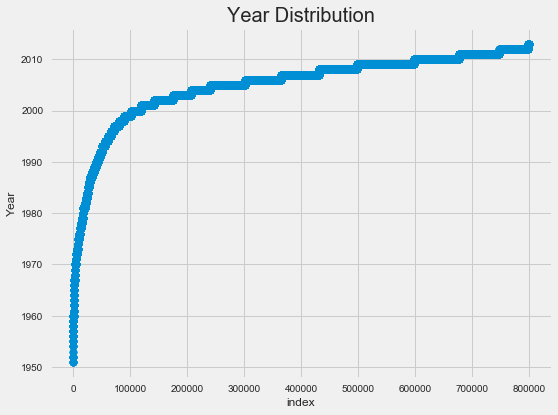

In [120]:
ydf = df[df["Year"]!=0].iloc[:800000,]
plt.figure(figsize=(8,6))
plt.scatter(range(ydf.shape[0]), np.sort(ydf["Year"].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.title("Year Distribution", fontsize=20) 
plt.show()

In [28]:
print(df.dtypes)

PaperTitle           object
Authors              object
Year                  int64
Publication_Venue    object
Index_Id              int64
References_Id        object
Abstract             object
count_reference       int64
dtype: object


In [29]:
df["Index_Id"].unique()
print(any(df['Index_Id'].duplicated())) 
print(len(df['Index_Id'].unique()))
print(len(df.index))

False
976233
976233


In [30]:
df[df.duplicated(subset="Index_Id")]

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract,count_reference


In [31]:
reference_count = {}
for references in df[df["References_Id"].notnull()]["References_Id"]:
    ref_list = map(int,references.strip(":").split(":"))
    for ref in ref_list:
        if ref in reference_count:
            reference_count[ref] += 1
        else:
            reference_count[ref] = 1
print(reference_count[2381731])

76236


In [32]:
def update_ref_count(row):
    if row['Index_Id'] in reference_count:
        return reference_count[row['Index_Id']]
    else:
        return 0
df["count_reference"] = df.apply(lambda row: update_ref_count(row),axis=1)

In [33]:
print(df.head(5))

                                            PaperTitle  \
117                     Algorithms for trie compaction   
133  Logical, internal, and physical reference beha...   
134    A parallel pipelined relational query processor   
147           Practical data-swapping: the first steps   
149  An extension of conflict-free multivalued depe...   

                                    Authors  Year  \
117              M. Al-Suwaiyel, E Horowitz  1984   
133  Wolfgang Effelsberg, Mary E. S. Loomis  1984   
134   Won Kim, Daniel Gajski, David J. Kuck  1984   
147                         Steven P. Reiss  1984   
149                        Hirofumi Katsuno  1984   

                               Publication_Venue  Index_Id  \
117  ACM Transactions on Database Systems (TODS)       118   
133  ACM Transactions on Database Systems (TODS)       134   
134  ACM Transactions on Database Systems (TODS)       135   
147  ACM Transactions on Database Systems (TODS)       148   
149  ACM Transactions 

In [34]:
sorted_by_value = sorted(reference_count.items(), key=lambda kv: kv[1],reverse=True)
print(sorted_by_value[:10])
print([row[0] for row in sorted_by_value[:10]])
print([row[1] for row in sorted_by_value[:10]])

[(2135000, 884601), (2381731, 76236), (408395, 8038), (369235, 6269), (190580, 5233), (136349, 4726), (729436, 4439), (168250, 4413), (760804, 4147), (115607, 3360)]
[2135000, 2381731, 408395, 369235, 190580, 136349, 729436, 168250, 760804, 115607]
[884601, 76236, 8038, 6269, 5233, 4726, 4439, 4413, 4147, 3360]


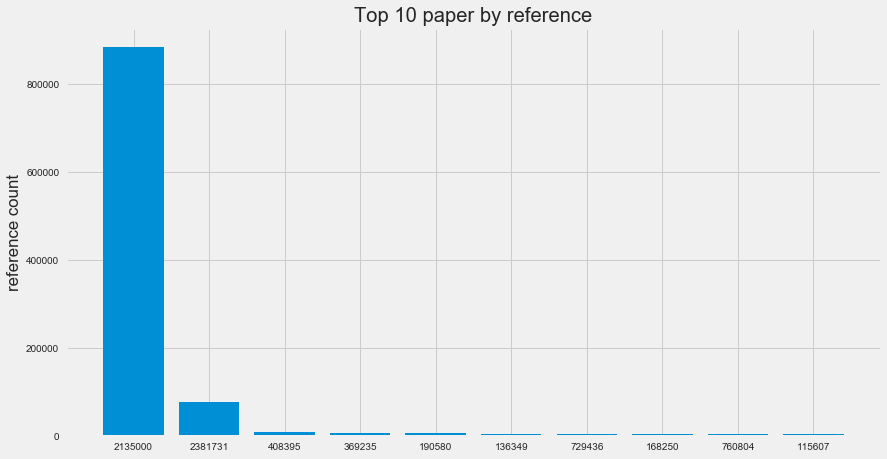

In [35]:
x_values = [row[0] for row in sorted_by_value[:10]]
y_values = [row[1] for row in sorted_by_value[:10]]
x_pos = np.arange(len(x_values))
plt.figure(figsize=(13,7))
plt.bar(x_pos,y_values, align='center', alpha=1)
plt.xticks(x_pos,x_values)
plt.ylabel('reference count')
plt.title('Top 10 paper by reference')
 
plt.show()

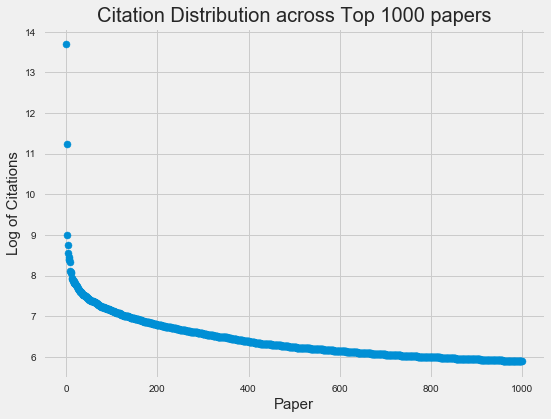

In [136]:
# df_train["totals_transactionRevenue"] = df_train["totals_transactionRevenue"].astype('float')
# gdf = df_train.groupby("fullVisitorId")["totals_transactionRevenue"].sum().reset_index()
x_values = [row[0] for row in sorted_by_value[:1000]]
y_values = [row[1] for row in sorted_by_value[:1000]]
# x_pos = np.arange(len(x_values))
# plt.figure(figsize=(13,7))
# plt.bar(x_pos,y_values, align='center', alpha=1)
# plt.xticks(x_pos,x_values)
# plt.ylabel('reference count')
# plt.title('Top 10 paper by reference')
 
# plt.show()



plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,6))
# dist_graph = plt.scatter(range(len(x_values)), np.sort(np.log1p(y_values)))
dist_graph = plt.scatter(range(len(x_values)), sorted(np.log1p(y_values), reverse=True))
plt.xlabel('Paper', fontsize=15)
plt.ylabel('Log of Citations', fontsize=15)
plt.title("Citation Distribution across Top 1000 papers", fontsize=20) 
plt.show()

ValueError: x and y must be the same size

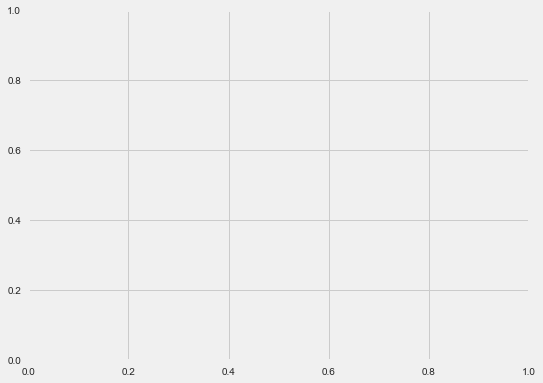

In [129]:
# df_train["totals_transactionRevenue"] = df_train["totals_transactionRevenue"].astype('float')
# gdf = df_train.groupby("fullVisitorId")["totals_transactionRevenue"].sum().reset_index()
x_values = [row[0] for row in sorted_by_value[:1000]]
y_values = np.log1p([row[1] for row in sorted_by_value[:1000]])
# x_pos = np.arange(len(x_values))
# plt.figure(figsize=(13,7))
# plt.bar(x_pos,y_values, align='center', alpha=1)
# plt.xticks(x_pos,x_values)
# plt.ylabel('reference count')
# plt.title('Top 10 paper by reference')
 
# plt.show()



plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,6))
# dist_graph = plt.scatter(range(len(x_values)), np.sort(np.log1p(y_values)))
dist_graph = plt.scatter(range(int(np.log1p(len(x_values)))), np.sort(y_values))
plt.xlabel('Paper', fontsize=12)
plt.ylabel('Citations', fontsize=12)
plt.title("Citation Distribution across papers", fontsize=20) 
plt.show()

In [36]:
print(df.shape)
df.isna().sum()

(976233, 8)


PaperTitle           0
Authors              0
Year                 0
Publication_Venue    0
Index_Id             0
References_Id        0
Abstract             0
count_reference      0
dtype: int64

In [151]:
# del reference_count
outlink_map = {}
inlink_map = {}
df_new = df[df["References_Id"].notnull()]
for index, row in df_new.iterrows():
    ref = row["References_Id"]
    ref_list = list(map(int,ref.strip(":").split(":")))
    outlink_map[row["Index_Id"]] = ref_list
    for ref in ref_list:
        listi = inlink_map.get(ref, [])
        listi.append(row["Index_Id"])
        inlink_map[ref] = listi

In [152]:
def calculate_page_rank():
    count = 0
    page_year = {row["Index_Id"]:row["Year"] for _t, row in df.iterrows()}
    year_citation_count = { page_year[index]:0 for index in page_year}
    year_paper_count = { page_year[index]:0 for index in page_year}
    avg_year_citation_count = {}
    for index in page_year:
        year = page_year[index]
        len_outlink = len(outlink_map.get(index, []))
        if len_outlink > 0:
            year_citation_count[year] += len_outlink
            year_paper_count[year] += 1
    for year in year_citation_count:
        if year_paper_count[year] > 0:
            avg_year_citation_count[year] = year_citation_count[year]/year_paper_count[year]
    page_rank = {}
    updated_page_rank = {}
    for index in df["Index_Id"]:
        page_rank[index] = 1
    while True:
        count += 1
        flag = True
        for key in page_rank:
            cs = page_rank[key]
            if key in inlink_map:
                inlink_list = inlink_map[key]
                ns = 0
                for link in inlink_list:
                    if link in page_rank and link in outlink_map:
                        ns += page_rank[link]/len(outlink_map[link])
                #ns = 0.15 + (0.85 * ns)
                ns = 0.15 + float(0.85) * (ns/avg_year_citation_count[page_year[key]])
                if cs != ns:
                    flag = False
                updated_page_rank[key] = ns
        if flag == True:
            print(count)
            break
        page_rank = updated_page_rank
        updated_page_rank = {}
        max_score = max(page_rank.values())
        print(f"max score is {max_score}")
        page_rank = { index:score/max_score for index, score in page_rank.items()}
        return page_rank

In [153]:
page_rank = calculate_page_rank()
#del outlink_map
#del inlink_map

max score is 45.30006518885713


In [154]:
page_rank
print(max(page_rank.values()))
print(sum(page_rank.values()))

1.0
2617.283945650123


In [155]:
df["page_rank"] = 0

In [156]:
def update_rank(row):
    if row["Index_Id"] in page_rank:
        return page_rank[row["Index_Id"]]
    else:
        return 0

In [157]:
df["page_rank"] = df.apply(lambda row: update_rank(row),axis = 1)

In [159]:
df.head(5)

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract,count_reference,Number Of Authors,page_rank
117,Algorithms for trie compaction,"M. Al-Suwaiyel, E Horowitz",1984,ACM Transactions on Database Systems (TODS),118,:1157:252607:287497:289080:408503:326292:32687...,The trie data structure has many properties wh...,12,2,0.004683
133,"Logical, internal, and physical reference beha...","Wolfgang Effelsberg, Mary E. S. Loomis",1984,ACM Transactions on Database Systems (TODS),134,:286819:287482:287680:287739:287766:287646:317...,This work investigates one aspect of the perfo...,9,2,0.005583
134,A parallel pipelined relational query processor,"Won Kim, Daniel Gajski, David J. Kuck",1984,ACM Transactions on Database Systems (TODS),135,:287004:287293:287666:287494:317954:321467:322...,This paper presents the design of a relational...,8,3,0.005590
147,Practical data-swapping: the first steps,Steven P. Reiss,1984,ACM Transactions on Database Systems (TODS),148,:287296:287297:289164:649353:2135000,The problem of statistical database confidenti...,38,1,0.010586
149,An extension of conflict-free multivalued depe...,Hirofumi Katsuno,1984,ACM Transactions on Database Systems (TODS),150,:287338:287676:289281:289349:289304:289423:374...,"Several researchers (Beeri, Bernstein, Chiu, F...",3,1,0.003931


In [38]:
df.head(5)

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract,count_reference
117,Algorithms for trie compaction,"M. Al-Suwaiyel, E Horowitz",1984,ACM Transactions on Database Systems (TODS),118,:1157:252607:287497:289080:408503:326292:32687...,The trie data structure has many properties wh...,12
133,"Logical, internal, and physical reference beha...","Wolfgang Effelsberg, Mary E. S. Loomis",1984,ACM Transactions on Database Systems (TODS),134,:286819:287482:287680:287739:287766:287646:317...,This work investigates one aspect of the perfo...,9
134,A parallel pipelined relational query processor,"Won Kim, Daniel Gajski, David J. Kuck",1984,ACM Transactions on Database Systems (TODS),135,:287004:287293:287666:287494:317954:321467:322...,This paper presents the design of a relational...,8
147,Practical data-swapping: the first steps,Steven P. Reiss,1984,ACM Transactions on Database Systems (TODS),148,:287296:287297:289164:649353:2135000,The problem of statistical database confidenti...,38
149,An extension of conflict-free multivalued depe...,Hirofumi Katsuno,1984,ACM Transactions on Database Systems (TODS),150,:287338:287676:289281:289349:289304:289423:374...,"Several researchers (Beeri, Bernstein, Chiu, F...",3


In [39]:
df["Number Of Authors"] = 0
def cal_authors(authors):
    return len(authors.split(","))
df["Number Of Authors"] = df["Authors"].apply(lambda val:cal_authors(val))
df["Number Of Authors"].value_counts()

2      299722
3      257046
1      154673
4      145068
5       64730
6       28854
7       12060
8        6066
9        3074
10       1731
11       1039
12        631
13        422
14        312
15        190
16        124
17        102
18         88
19         45
20         43
21         37
22         30
24         21
23         20
26         16
27         14
25         14
29          9
28          8
30          6
31          6
33          3
37          3
38          2
83          2
45          2
42          2
39          2
34          2
32          2
110         1
41          1
36          1
43          1
46          1
50          1
52          1
59          1
63          1
65          1
77          1
115         1
Name: Number Of Authors, dtype: int64

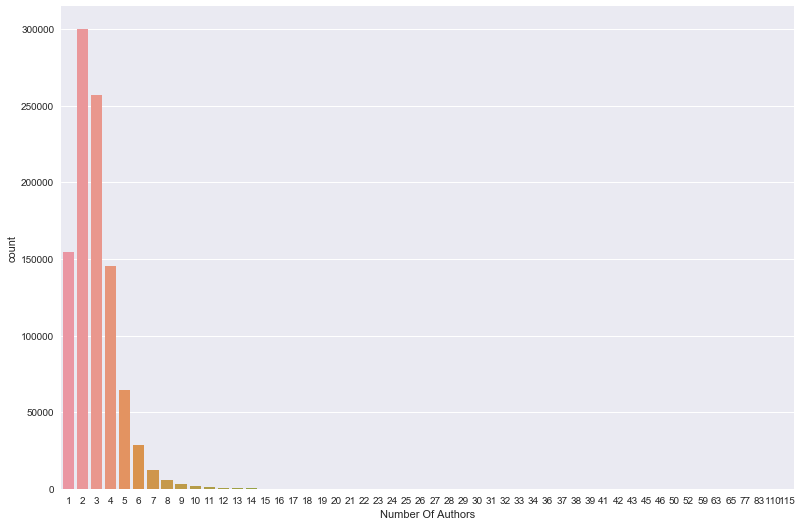

In [51]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="darkgrid")
ax = sns.countplot(x="Number Of Authors", data=df)
# ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

Text(0,0.5,'Count')

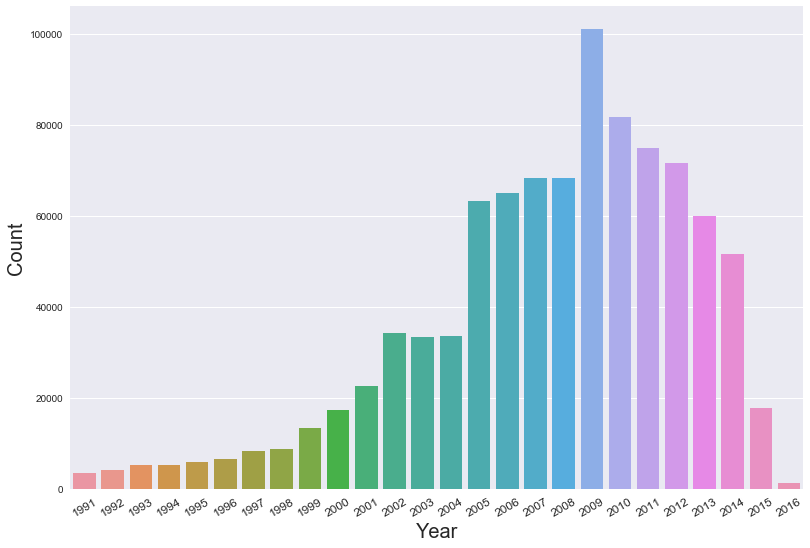

In [125]:
import seaborn as sns
year_df = df[df["Year"]> 1990]
sns.set(font_scale=2, rc={'figure.figsize':(11.7,8.27)})
# sns.set_context("notebook", , rc={"lines.linewidth": 2.5})
sns.set(style="darkgrid")
ax = sns.countplot(x="Year", data=year_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,fontsize=12)
# ax.set_yticklabels(ax.get_yticklabels(),fontsize=12)
ax.set_xlabel('Year',fontsize=20)
ax.set_ylabel('Count',fontsize=20)


# Text on the top of each barplot
# for i in range(len()):
# ax.text(x = r4[i]-0.5 , y = bars4[i]+0.1, s = label[i], size = 6)

In [66]:
page_year = {row["Index_Id"]:row["Year"] for _t, row in df.iterrows() if  row["Year"]>1990}
year_citation_count = { page_year[index]:0 for index in page_year}
year_paper_count = { page_year[index]:0 for index in page_year}
avg_year_citation_count = {}
for index in page_year:
    year = page_year[index]
    len_outlink = len(outlink_map.get(index, []))
    if len_outlink > 0:
        year_citation_count[year] += len_outlink
        year_paper_count[year] += 1
# for year in year_citation_count:
#     if year_paper_count[year] > 0:
#         avg_year_citation_count[year] = year_citation_count[year]/year_paper_count[year]
# import matplotlib.pylab as plt
# lists = sorted(year_citation_count.items()) # sorted by key, return a list of tuples
# x, y = zip(*lists) # unpack a list of pairs into two tuples
# plt.plot(x, y)
# plt.show()

In [82]:
sns.set(font_scale=1.5, rc={'figure.figsize':(11.7,8.27)})
# sns.set_context("notebook", , rc={"lines.linewidth": 2.5})
sns.set(style="darkgrid")
year_cite_df = pd.DataFrame(year_citation_count)
ax = sns.countplot(x = year_cite_df.keys(), data=year_cite_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set_xlabel('Year',fontsize=20)
ax.set_ylabel('Citations',fontsize=20)

ValueError: If using all scalar values, you must pass an index

In [80]:
year_citation_count.keys()

dict_keys([2000, 1991, 1992, 1993, 1994, 1995, 2011, 1996, 1997, 1998, 1999, 2001, 2002, 2009, 2003, 2010, 2004, 2005, 2006, 2007, 2008, 2013, 2012, 2014, 2015, 2016])

In [71]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_vals = list(df_new["Publication_Venue"].values.astype(str))
le.fit(train_vals)
df_new["Publication_Venue"] = le.transform(train_vals)

In [72]:
df["Number Of Authors"].value_counts()

2      299722
3      257046
1      154673
4      145068
5       64730
6       28854
7       12060
8        6066
9        3074
10       1731
11       1039
12        631
13        422
14        312
15        190
16        124
17        102
18         88
19         45
20         43
21         37
22         30
24         21
23         20
26         16
27         14
25         14
29          9
28          8
30          6
31          6
33          3
37          3
38          2
83          2
45          2
42          2
39          2
34          2
32          2
110         1
41          1
36          1
43          1
46          1
50          1
52          1
59          1
63          1
65          1
77          1
115         1
Name: Number Of Authors, dtype: int64

In [73]:
# graph 
adj_list = {}
for key,row in df.iterrows():
    curr_list = adj_list.get(row["Index_Id"], [])
    curr_list.extend(list(map(int,row["References_Id"].strip(":").split(":"))))
    curr_list = list(set(curr_list))
    adj_list[key] = curr_list
adj_list

{117: [688701,
  1157,
  287497,
  326292,
  408503,
  289080,
  2135000,
  326877,
  287326,
  252607],
 133: [287680,
  286819,
  317987,
  323270,
  1825959,
  690249,
  318031,
  319472,
  321685,
  287766,
  407995,
  2135000,
  287482,
  287739,
  482045,
  287646,
  411551],
 134: [317954,
  287494,
  689435,
  287004,
  411679,
  411553,
  599212,
  599214,
  599215,
  287666,
  689976,
  689210,
  321467,
  287293,
  322879,
  599234,
  689860,
  426453,
  2135000,
  607453,
  606177,
  481891],
 147: [287296, 287297, 649353, 289164, 2135000],
 149: [416000,
  289281,
  289349,
  287338,
  289423,
  374000,
  411567,
  598678,
  2135000,
  289304,
  411705,
  287676],
 315: [321968, 2135000, 555374, 764431],
 316: [2135000],
 317: [399234,
  341247,
  287332,
  286855,
  320232,
  287369,
  286830,
  287630,
  374000,
  287729,
  411698,
  534063,
  566099,
  287477,
  2007,
  2135000,
  286972,
  408061,
  322879],
 318: [555361,
  318212,
  320203,
  565837,
  680046,
  4085

In [97]:
# dfs
def reach(n):
    visited = {}
    visited[n] = True
    max_count = -1
    count = 0
    
    if n in adj_list:
        neighbours = adj_list[n]
        for node in neighbours:
            if node not in visited:
                visited[node] = True
                print(node,end=" ")
                count = 1+ reach(node)
                if count>max_count:
                    max_count = count
        print("\n####")
    else:
        return 0
    return max_count

In [96]:
import sys
sys.setrecursionlimit(100000)

In [89]:
sys.getrecursionlimit()

NameError: name 'sys' is not defined

In [99]:
reach(711)

537568 531906 317987 287365 607424 287650 685699 2135000 607467 606528 606530 2135000 
####
325127 2135000 323800 325149 
####
686145 835725 322770 2135000 323965 323326 325746 
####
322879 2135000 325145 
####

####
601709 2135000 320593 341227 323272 686731 323287 2135000 321689 2135000 35451 288908 834986 18573 2135000 288666 288381 601533 2135000 288497 288369 
####
602125 2135000 
####
601535 601539 2135000 288289 
####
288584 2135000 288425 326793 288266 327017 325928 326793 325934 805936 288243 2135000 805944 
####
325836 2135000 288254 
####
288523 2135000 840583 
####
288297 
####
328073 2135000 
####
326793 1373384 2135000 1316956 
####
325836 325037 1373389 1373670 2135000 288505 1115253 835095 
####
288775 1373675 840583 288523 2135000 840583 
####
288366 835095 2135000 1373597 1373654 1373367 2135000 1373373 1373666 840583 288469 2135000 288425 326793 288266 327017 325928 326793 325934 805936 288243 2135000 805944 
####
325836 2135000 288254 
####

####
835095 2135000 2885

1148906 323272 2135000 
####
2135000 
####
1011785 2135000 1003953 
####
1012592 317920 598630 598913 602678 321498 288642 2135000 288467 2135000 
####
669300 
####
288580 2135000 288218 326889 288082 2135000 288025 326814 
####
684740 288212 
####
671720 671982 321682 208834 132305 12434 1068417 319017 2135000 317884 319215 
####
1450 408395 1080799 1373609 2135000 
####
815 672335 408637 17844 596725 411621 399232 320901 2135000 322530 
####
287750 346828 2135000 287346 508936 237609 444482 133060 323270 442093 112199 89799 58186 1569 3041 1011428 2135000 1012849 
####
1010533 840608 1012232 606601 2135000 
####
1148906 323272 2135000 
####
2135000 
####
1011785 2135000 1003953 
####
1012592 317920 598630 598913 602678 321498 288642 2135000 288467 2135000 
####
669300 
####
288580 2135000 288218 326889 288082 2135000 288025 326814 
####
684740 288212 
####
671720 671982 321682 208834 132305 12434 1068417 319017 2135000 317884 319215 
####
1450 408395 1080799 1373609 2135000 
####
815

287750 346828 2135000 287346 508936 237609 444482 133060 323270 442093 112199 89799 58186 1569 3041 1011428 2135000 1012849 
####
1010533 840608 1012232 606601 2135000 
####
1148906 323272 2135000 
####
2135000 
####
1011785 2135000 1003953 
####
1012592 317920 598630 598913 602678 321498 288642 2135000 288467 2135000 
####
669300 
####
288580 2135000 288218 326889 288082 2135000 288025 326814 
####
684740 288212 
####
671720 671982 321682 208834 132305 12434 1068417 319017 2135000 317884 319215 
####
1450 408395 1080799 1373609 2135000 
####
815 672335 408637 17844 596725 411621 399232 320901 2135000 322530 
####
287750 346828 2135000 287346 508936 237609 444482 133060 323270 442093 112199 89799 58186 1569 3041 1011428 2135000 1012849 
####
1010533 840608 1012232 606601 2135000 
####
1148906 323272 2135000 
####
2135000 
####
1011785 2135000 1003953 
####
1012592 317920 598630 598913 602678 321498 288642 2135000 288467 2135000 
####
669300 
####
288580 2135000 288218 326889 288082 213

815 672335 408637 17844 596725 411621 399232 320901 2135000 322530 
####
287750 346828 2135000 287346 508936 237609 444482 133060 323270 442093 112199 89799 58186 1569 3041 1011428 2135000 1012849 
####
1010533 840608 1012232 606601 2135000 
####
1148906 323272 2135000 
####
2135000 
####
1011785 2135000 1003953 
####
1012592 317920 598630 598913 602678 321498 288642 2135000 288467 2135000 
####
669300 
####
288580 2135000 288218 326889 288082 2135000 288025 326814 
####
684740 288212 
####
671720 671982 321682 208834 132305 12434 1068417 319017 2135000 317884 319215 
####
1450 408395 1080799 1373609 2135000 
####
815 672335 408637 17844 596725 411621 399232 320901 2135000 322530 
####
287750 346828 2135000 287346 508936 237609 444482 133060 323270 442093 112199 89799 58186 1569 3041 1011428 2135000 1012849 
####
1010533 840608 1012232 606601 2135000 
####
1148906 323272 2135000 
####
2135000 
####
1011785 2135000 1003953 
####
1012592 317920 598630 598913 602678 321498 288642 2135000 

1012592 317920 598630 598913 602678 321498 288642 2135000 288467 2135000 
####
669300 
####
288580 2135000 288218 326889 288082 2135000 288025 326814 
####
684740 288212 
####
671720 671982 321682 208834 132305 12434 1068417 319017 2135000 317884 319215 
####
1450 408395 1080799 1373609 2135000 
####
815 672335 408637 17844 596725 411621 399232 320901 2135000 322530 
####
287750 346828 2135000 287346 508936 237609 444482 133060 323270 442093 112199 89799 58186 1569 3041 1011428 2135000 1012849 
####
1010533 840608 1012232 606601 2135000 
####
1148906 323272 2135000 
####
2135000 
####
1011785 2135000 1003953 
####
1012592 317920 598630 598913 602678 321498 288642 2135000 288467 2135000 
####
669300 
####
288580 2135000 288218 326889 288082 2135000 288025 326814 
####
684740 288212 
####
671720 671982 321682 208834 132305 12434 1068417 319017 2135000 317884 319215 
####
1450 408395 1080799 1373609 2135000 
####
815 672335 408637 17844 596725 411621 399232 320901 2135000 322530 
####
287

815 672335 408637 17844 596725 411621 399232 320901 2135000 322530 
####
287750 346828 2135000 287346 508936 237609 444482 133060 323270 442093 112199 89799 58186 1569 3041 1011428 2135000 1012849 
####
1010533 840608 1012232 606601 2135000 
####
1148906 323272 2135000 
####
2135000 
####
1011785 2135000 1003953 
####
1012592 317920 598630 598913 602678 321498 288642 2135000 288467 2135000 
####
669300 
####
288580 2135000 288218 326889 288082 2135000 288025 326814 
####
684740 288212 
####
671720 671982 321682 208834 132305 12434 1068417 319017 2135000 317884 319215 
####
1450 408395 1080799 1373609 2135000 
####
815 672335 408637 17844 596725 411621 399232 320901 2135000 322530 
####
287750 346828 2135000 287346 508936 237609 444482 133060 323270 442093 112199 89799 58186 1569 3041 1011428 2135000 1012849 
####
1010533 840608 1012232 606601 2135000 
####
1148906 323272 2135000 
####
2135000 
####
1011785 2135000 1003953 
####
1012592 317920 598630 598913 602678 321498 288642 2135000 

1012592 317920 598630 598913 602678 321498 288642 2135000 288467 2135000 
####
669300 
####
288580 2135000 288218 326889 288082 2135000 288025 326814 
####
684740 288212 
####
671720 671982 321682 208834 132305 12434 1068417 319017 2135000 317884 319215 
####
1450 408395 1080799 1373609 2135000 
####
815 672335 408637 17844 596725 411621 399232 320901 2135000 322530 
####
287750 346828 2135000 287346 508936 237609 444482 133060 323270 442093 112199 89799 58186 1569 3041 1011428 2135000 1012849 
####
1010533 840608 1012232 606601 2135000 
####
1148906 323272 2135000 
####
2135000 
####
1011785 2135000 1003953 
####
1012592 317920 598630 598913 602678 321498 288642 2135000 288467 2135000 
####
669300 
####
288580 2135000 288218 326889 288082 2135000 288025 326814 
####
684740 288212 
####
671720 671982 321682 208834 132305 12434 1068417 319017 2135000 317884 319215 
####
1450 408395 1080799 1373609 2135000 
####
815 672335 408637 17844 596725 411621 399232 320901 2135000 322530 
####
287

1011785 2135000 1003953 
####
1012592 317920 598630 598913 602678 321498 288642 2135000 288467 2135000 
####
669300 
####
288580 2135000 288218 326889 288082 2135000 288025 326814 
####
684740 288212 
####
671720 671982 321682 208834 132305 12434 1068417 319017 2135000 317884 319215 
####
1450 408395 1080799 1373609 2135000 
####
815 672335 408637 17844 596725 411621 399232 320901 2135000 322530 
####
287750 346828 2135000 287346 508936 237609 444482 133060 323270 442093 112199 89799 58186 1569 3041 1011428 2135000 1012849 
####
1010533 840608 1012232 606601 2135000 
####
1148906 323272 2135000 
####
2135000 
####
1011785 2135000 1003953 
####
1012592 317920 598630 598913 602678 321498 288642 2135000 288467 2135000 
####
669300 
####
288580 2135000 288218 326889 288082 2135000 288025 326814 
####
684740 288212 
####
671720 671982 321682 208834 132305 12434 1068417 319017 2135000 317884 319215 
####
1450 408395 1080799 1373609 2135000 
####
815 672335 408637 17844 596725 411621 399232 3

671720 671982 321682 208834 132305 12434 1068417 319017 2135000 317884 319215 
####
1450 408395 1080799 1373609 2135000 
####
815 672335 408637 17844 596725 411621 399232 320901 2135000 322530 
####
287750 346828 2135000 287346 508936 237609 444482 133060 323270 442093 112199 89799 58186 1569 3041 1011428 2135000 1012849 
####
1010533 840608 1012232 606601 2135000 
####
1148906 323272 2135000 
####
2135000 
####
1011785 2135000 1003953 
####
1012592 317920 598630 598913 602678 321498 288642 2135000 288467 2135000 
####
669300 
####
288580 2135000 288218 326889 288082 2135000 288025 326814 
####
684740 288212 
####
671720 671982 321682 208834 132305 12434 1068417 319017 2135000 317884 319215 
####
1450 408395 1080799 1373609 2135000 
####
815 672335 408637 17844 596725 411621 399232 320901 2135000 322530 
####
287750 346828 2135000 287346 508936 237609 444482 133060 323270 442093 112199 89799 58186 1569 3041 1011428 2135000 1012849 
####
1010533 840608 1012232 606601 2135000 
####
11489

RecursionError: maximum recursion depth exceeded in comparison

In [83]:
adj_list[252607]

KeyError: 252607

In [109]:
df[df["Index_Id"] == 711]

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract,count_reference,Number Of Authors


In [25]:
def tidy_split(df, column, sep='|', keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.

    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df

In [140]:
df_new = tidy_split(df, 'Authors', sep=',')
df_new.head()

NameError: name 'tidy_split' is not defined

In [163]:
df.sort_values("page_rank",ascending=False).head(10)

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract,count_reference,Number Of Authors,page_rank
319992,A method for obtaining digital signatures and ...,"R. L. Rivest, A. Shamir, L. Adleman",1978,Communications of the ACM,319993,:243298:320110:599922:2135000,An encryption method is presented with the nov...,2097,3,1.000000
322878,A relational model of data for large shared da...,E. F. Codd,1970,Communications of the ACM,322879,:323870:602084:2135000,Future users of large data banks must be prote...,1319,1,0.968686
288819,Scheduling Algorithms for Multiprogramming in ...,"C. L. Liu, James W. Layland",1973,Journal of the ACM (JACM),288820,:288212:288509:288674:317761:322748:323273:326...,The problem of multiprogram scheduling on a si...,1538,2,0.770289
760803,Distinctive Image Features from Scale-Invarian...,David G. Lowe,2004,International Journal of Computer Vision,760804,:90845:103571:146346:154674:198349:227525:2523...,This paper presents a method for extracting di...,4147,1,0.714130
319847,How to share a secret,Adi Shamir,1979,Communications of the ACM,319848,:243298:319993:408637:2135000,In this paper we show how to divide data D int...,1534,1,0.600616
327777,A machine program for theorem-proving,"Martin Davis, George Logemann, Donald Loveland",1962,Communications of the ACM,327778,:288164:2135000,The programming of a proof procedure is discus...,773,3,0.594996
323375,An axiomatic basis for computer programming,C. A. R. Hoare,1969,Communications of the ACM,323376,:806053:2135000,In this paper an attempt is made to explore th...,1003,1,0.593428
449586,Induction of Decision Trees,J. R. Quinlan,1986,Machine Learning,449587,:52823:2135000,The technology for building knowledge-based sy...,1991,1,0.592007
320185,"Time, clocks, and the ordering of events in a ...",Leslie Lamport,1978,Communications of the ACM,320186,:2135000,The concept of one event happening before anot...,1719,1,0.585010
319462,Random sample consensus: a paradigm for model ...,"Martin A. Fischler, Robert C. Bolles",1981,Communications of the ACM,319463,:55350:2135000,"A new paradigm, Random Sample Consensus (RANSA...",1557,2,0.559871


In [141]:
#df_new = b
df_new.head

<bound method NDFrame.head of                                                 PaperTitle  \
117                         Algorithms for trie compaction   
133      Logical, internal, and physical reference beha...   
134        A parallel pipelined relational query processor   
147               Practical data-swapping: the first steps   
149      An extension of conflict-free multivalued depe...   
315      A Formal Method for the Abstract Specification...   
316        On the Optimal Solution of Large Linear Systems   
317      The Format Model: A Theory of database Organiz...   
318         A Theory of Communicating Sequential Processes   
319      Highly available systems for database applicat...   
320      Multiple-access protocols and time-constrained...   
321                                         Local networks   
325                     Faster methods for random sampling   
469      SYSTEM/U: a database system based on the unive...   
505      Resolving the query inference p

In [33]:
train_vals = list(df_new["Authors"].values.astype(str))
le.fit(train_vals)
df_new["Authors"] = le.transform(train_vals)

In [ ]:
df_new.to_csv("ranked_processed_acm_1.csv")

In [35]:
df_new.head(5)

,PaperTitle,Authors,Year,Publication_Venue,Index_Id,References_Id,Abstract,count_reference,page_rank
117,Algorithms for trie compaction,207770,1984.0,11564,118,:1157:252607:287497:289080:408503:326292:32687...,The trie data structure has many properties wh...,12,0.004683
117,Algorithms for trie compaction,218707,1984.0,11564,118,:1157:252607:287497:289080:408503:326292:32687...,The trie data structure has many properties wh...,12,0.004683
133,"Logical, internal, and physical reference beha...",84699,1984.0,11564,134,:286819:287482:287680:287739:287766:287646:317...,This work investigates one aspect of the perfo...,9,0.005583
133,"Logical, internal, and physical reference beha...",558533,1984.0,11564,134,:286819:287482:287680:287739:287766:287646:317...,This work investigates one aspect of the perfo...,9,0.005583
134,A parallel pipelined relational query processor,88995,1984.0,11564,135,:287004:287293:287666:287494:317954:321467:322...,This paper presents the design of a relational...,8,0.005590


In [ ]:
num_columns= ["Year","Publication_Venue","Index_Id","count_reference","Number Of Authors"]
df_train = df[num_columns]

In [ ]:
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(df_train, df["page_rank"], test_size=0.25, random_state=20)

In [ ]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(train_x,train_y)
print(reg.coef_)

In [ ]:
from sklearn import metrics
pred_y = reg.predict(valid_x)
rmse_initial = np.sqrt(metrics.mean_squared_error(pred_y,valid_y))
print(rmse_initial)